# Compare Countries — Benin / Sierra Leone / Togo
**Objective:** Synthesize cleaned datasets to compare solar potential (GHI, DNI, DHI) and test for statistically significant differences.

In [19]:
# Cell 2 — Imports & plotting config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [20]:
# Cell 3 — Load cleaned datasets
paths = {
    "Benin": "../data/benin_clean.csv",
    "Sierra Leone": "../data/sierra_leone_clean.csv",
    "Togo": "../data/togo_clean.csv"
}

dfs = {}
for country, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file: {p} — put the cleaned CSV in data/")
    df = pd.read_csv(p, parse_dates=True, index_col=0) # Timestamp likely index column
    # Ensure expected cols exist
    for col in ['GHI','DNI','DHI']:
        if col not in df.columns:
            raise KeyError(f"{col} not found in {p}")
    dfs[country] = df

# Quick sanity checks
for c, df in dfs.items():
    print(f"{c}: rows={len(df)}, cols={list(df.columns)}")
    print(df[['GHI','DNI','DHI']].describe().T[['count','mean','std','50%']])
    print('-'*60)

Benin: rows=525600, cols=['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Country', 'GHI_z_outlier', 'DNI_z_outlier', 'DHI_z_outlier', 'ModA_z_outlier', 'ModB_z_outlier', 'WS_z_outlier', 'WSgust_z_outlier', 'any_z_outlier']
        count        mean         std  50%
GHI  525600.0  241.958821  330.101787  1.8
DNI  525600.0  167.441866  261.547532  0.0
DHI  525600.0  116.993033  157.463619  1.6
------------------------------------------------------------
Sierra Leone: rows=525600, cols=['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Country', 'GHI_z_outlier', 'DNI_z_outlier', 'DHI_z_outlier', 'ModA_z_outlier', 'ModB_z_outlier', 'WS_z_outlier', 'WSgust_z_outlier', 'any_z_outlier']
        count        mean         std  50%
GHI  525600.0  204.406778  296.787520  0.3


In [21]:
# Cell 4 — Combine into one dataframe with country label
combined = []
for country, df in dfs.items():
    tmp = df[['GHI','DNI','DHI']].copy()
    tmp = tmp.assign(Country=country)
    combined.append(tmp)
combined = pd.concat(combined, axis=0)
combined.reset_index(inplace=True, drop=True) # index not needed for plotting
combined['Country'] = combined['Country'].astype('category')

# Quick view
combined.head()

,GHI,DNI,DHI,Country
0,0.0,0.0,0.0,Benin
1,0.0,0.0,0.0,Benin
2,0.0,0.0,0.0,Benin
3,0.0,0.0,0.0,Benin
4,0.0,0.0,0.0,Benin


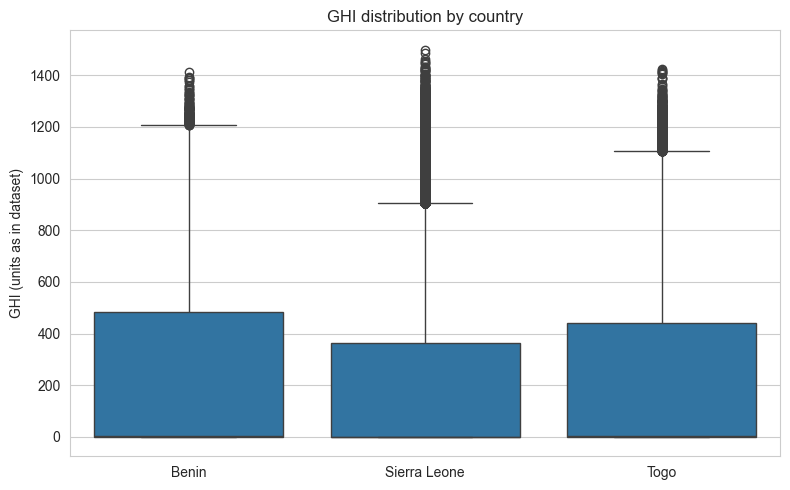

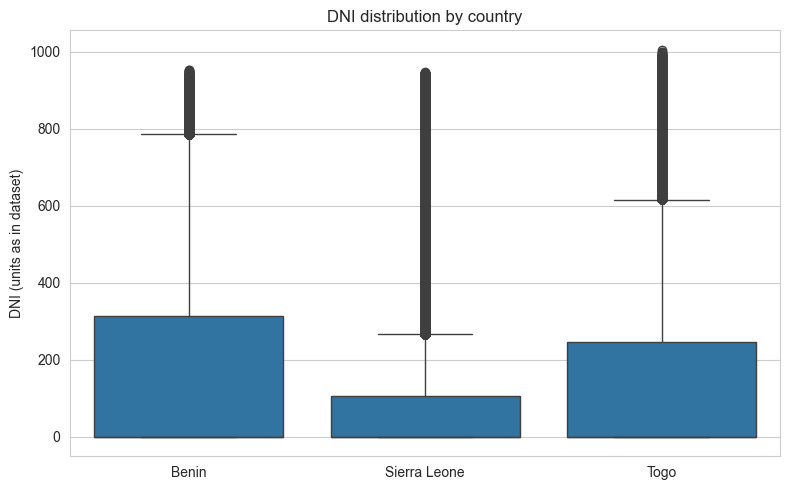

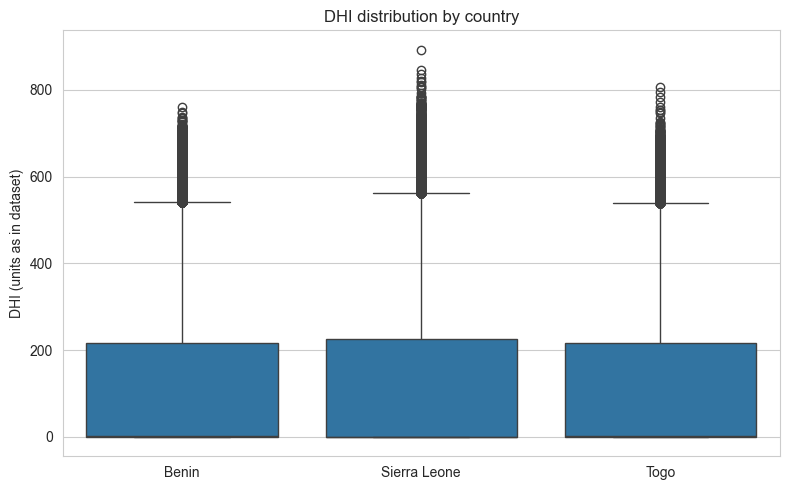

In [22]:
# Cell 5 — Boxplots for GHI, DNI, DHI
metrics = ['GHI','DNI','DHI']
for m in metrics:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=combined, x='Country', y=m)
    plt.title(f"{m} distribution by country")
    plt.ylabel(m + " (units as in dataset)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

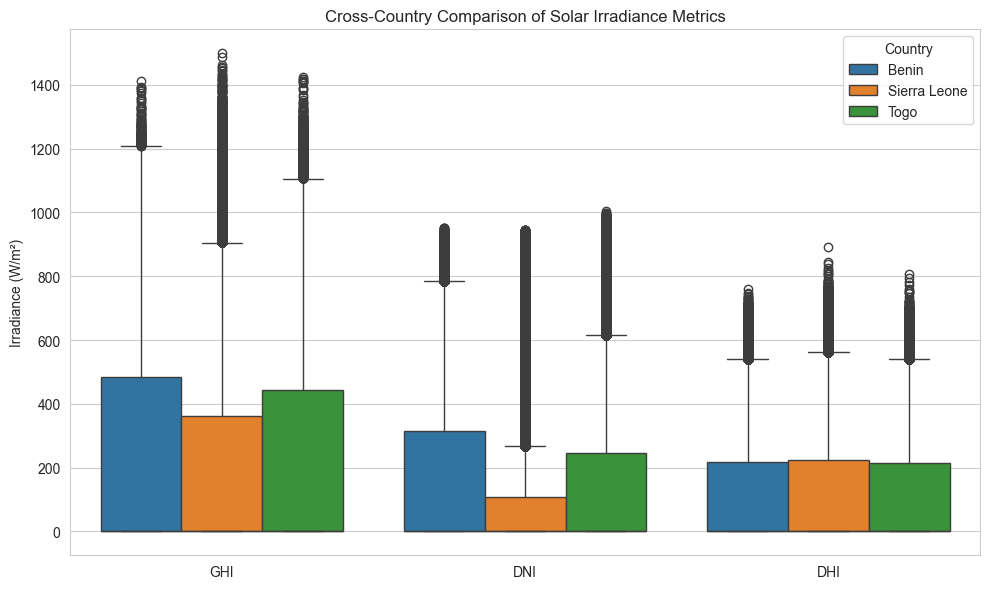

In [23]:
# Cell 6 — Combined Comparison of GHI, DNI, DHI
plt.figure(figsize=(10,6))
melted = combined.melt(
    id_vars='Country',
    value_vars=['GHI','DNI','DHI'],
    var_name='Metric',
    value_name='Value'
)
sns.boxplot(x='Metric', y='Value', hue='Country', data=melted)
plt.title('Cross-Country Comparison of Solar Irradiance Metrics')
plt.xlabel('')
plt.ylabel('Irradiance (W/m²)')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

In [24]:
# Cell 7 — Summary table
summary = combined.groupby('Country', observed=False)[['GHI','DNI','DHI']].agg(['mean','median','std']).round(3)
# flatten columns
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
display(summary)
# optionally save
summary.to_csv("../data/summary_stats_by_country.csv")
print("Saved summary table to ../data/summary_stats_by_country.csv (do NOT commit CSV)")

,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
Country,,,,,,,,,
Benin,241.959,1.8,330.102,167.442,0.0,261.548,116.993,1.6,157.464
Sierra Leone,204.407,0.3,296.788,116.524,0.0,218.574,116.274,0.0,157.021
Togo,231.719,2.1,321.692,151.258,0.0,250.957,116.444,2.5,156.521


Saved summary table to ../data/summary_stats_by_country.csv (do NOT commit CSV)


In [25]:
# Cell 8 — ANOVA on GHI (and alternative if assumptions fail)
# Prepare arrays for each country
ghi_groups = [dfs[c]['GHI'].dropna().values for c in dfs.keys()]

# 1) Check normality (Shapiro) on each group (note: Shapiro may be sensitive for large n)
print("Shapiro-Wilk normality test (GHI):")
for country, arr in zip(dfs.keys(), ghi_groups):
    if len(arr) < 3:
        print(country, "too few samples for Shapiro")
        continue
    stat, p = stats.shapiro(arr[:5000]) if len(arr) > 5000 else stats.shapiro(arr) # sample if huge
    print(f" {country}: W={stat:.4f}, p={p:.4e}")

# 2) Check variance homogeneity (Levene test)
levene_stat, levene_p = stats.levene(*ghi_groups)
print(f"\nLevene test (homogeneity of variances): stat={levene_stat:.4f}, p={levene_p:.4e}")

# 3) If normal & homoscedastic -> one-way ANOVA; else -> Kruskal-Wallis
if levene_p > 0.05:
    anova_stat, anova_p = stats.f_oneway(*ghi_groups)
    print(f"\nOne-way ANOVA on GHI: F={anova_stat:.4f}, p={anova_p:.4e}")
else:
    kw_stat, kw_p = stats.kruskal(*ghi_groups)
    print(f"\nKruskal-Wallis test (GHI): H={kw_stat:.4f}, p={kw_p:.4e}")


Shapiro-Wilk normality test (GHI):
 Benin: W=0.6875, p=2.5855e-70
 Sierra Leone: W=0.7016, p=2.2008e-69
 Togo: W=0.7380, p=8.4844e-67

Levene test (homogeneity of variances): stat=1988.6190, p=0.0000e+00

Kruskal-Wallis test (GHI): H=1377.9818, p=5.9572e-300


In [26]:
# Cell 9 — Kruskal-Wallis for DNI and DHI (nonparametric robust)
for metric in ['DNI','DHI']:
    groups = [dfs[c][metric].dropna().values for c in dfs.keys()]
    kw_stat, kw_p = stats.kruskal(*groups)
    print(f"{metric}: Kruskal-Wallis H={kw_stat:.4f}, p={kw_p:.4e}")

DNI: Kruskal-Wallis H=4272.9716, p=0.0000e+00
DHI: Kruskal-Wallis H=78.1595, p=1.0663e-17


Tukey HSD post-hoc test for GHI means between countries:

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper  reject
----------------------------------------------------------------
       Benin Sierra Leone  -37.552   0.0 -38.9991 -36.105   True
       Benin         Togo   -10.24   0.0 -11.6871  -8.793   True
Sierra Leone         Togo   27.312   0.0   25.865  28.759   True
----------------------------------------------------------------


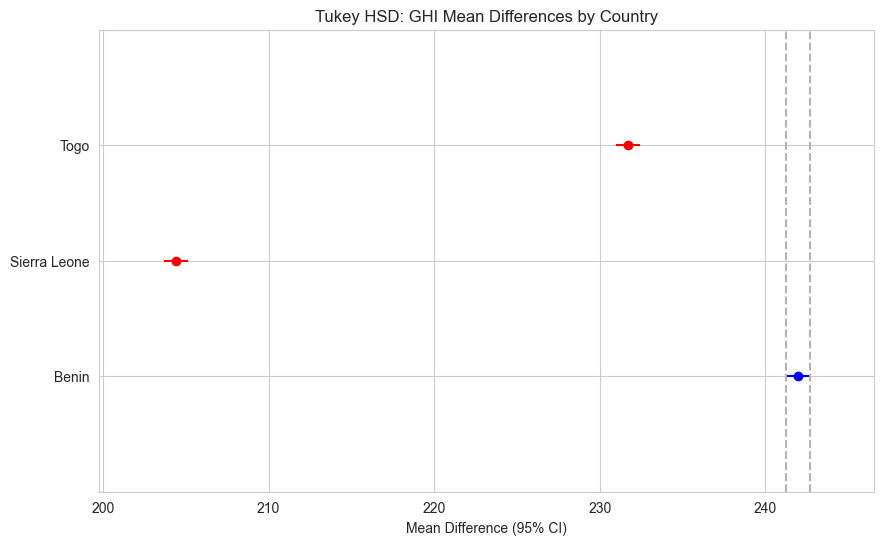

Tukey HSD post-hoc test for GHI means between countries:

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper  reject
----------------------------------------------------------------
       Benin Sierra Leone  -37.552   0.0 -38.9991 -36.105   True
       Benin         Togo   -10.24   0.0 -11.6871  -8.793   True
Sierra Leone         Togo   27.312   0.0   25.865  28.759   True
----------------------------------------------------------------


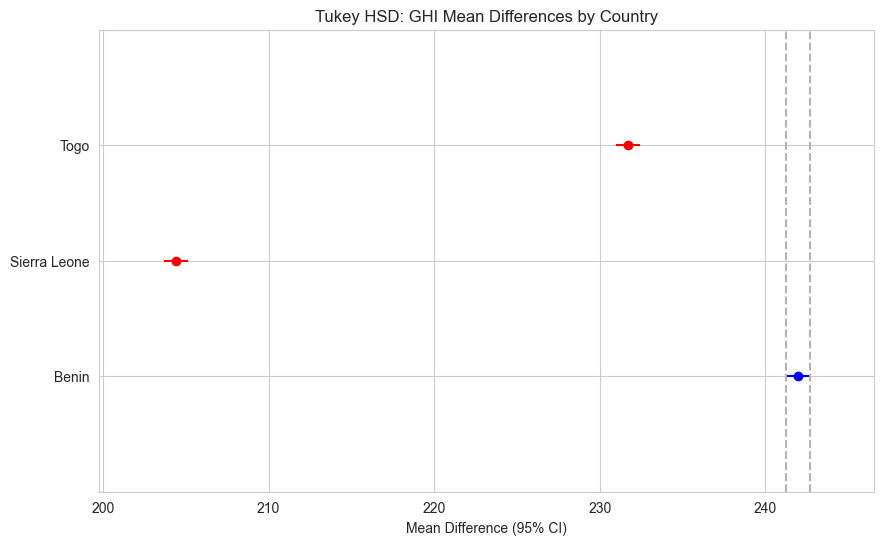

In [27]:
# Cell 10 — Post-hoc analysis using Tukey HSD (after ANOVA)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Tukey test only makes sense if ANOVA was significant (p < 0.05)
# You can still run it to explore mean differences.

print("Tukey HSD post-hoc test for GHI means between countries:\n")

# Ensure 'Country' is categorical
combined['Country'] = combined['Country'].astype('category')

tukey_result = pairwise_tukeyhsd(endog=combined['GHI'], groups=combined['Country'], alpha=0.05)
print(tukey_result)

# Optional visualization of Tukey result
fig = tukey_result.plot_simultaneous(comparison_name=combined['Country'].cat.categories[0])
plt.title("Tukey HSD: GHI Mean Differences by Country")
plt.xlabel("Mean Difference (95% CI)")
plt.show()# Cell 8.5 — Post-hoc analysis using Tukey HSD (after ANOVA)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Tukey test only makes sense if ANOVA was significant (p < 0.05)
# You can still run it to explore mean differences.

print("Tukey HSD post-hoc test for GHI means between countries:\n")

# Ensure 'Country' is categorical
combined['Country'] = combined['Country'].astype('category')

tukey_result = pairwise_tukeyhsd(endog=combined['GHI'], groups=combined['Country'], alpha=0.05)
print(tukey_result)

# Optional visualization of Tukey result
fig = tukey_result.plot_simultaneous(comparison_name=combined['Country'].cat.categories[0])
plt.title("Tukey HSD: GHI Mean Differences by Country")
plt.xlabel("Mean Difference (95% CI)")
plt.show()

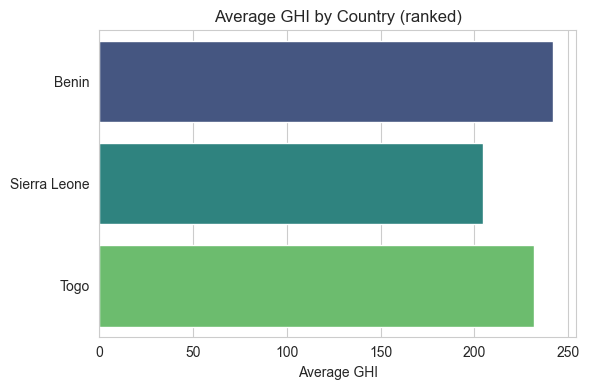

In [28]:
# Cell 11 — Ranking bar chart by average GHI
ghi_means = combined.groupby('Country', observed=False)['GHI'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=ghi_means.values, y=ghi_means.index, hue=ghi_means.index, palette='viridis', legend=False)
plt.title("Average GHI by Country (ranked)")
plt.xlabel("Average GHI")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [29]:
# Cell 12 — Save summary table for reporting
summary.to_csv("../data/comparison_summary_table.csv")
print("Saved comparison_summary_table.csv (do NOT commit CSV)")

Saved comparison_summary_table.csv (do NOT commit CSV)


🌍 Key Observations — Cross-Country Solar Potential

1. Solar Irradiance Trends

Benin shows the highest average GHI, indicating the strongest solar potential across the three countries.

Sierra Leone exhibits the lowest GHI and higher variability, likely due to higher humidity and cloud cover.

Togo presents moderate irradiance and relatively stable readings with fewer outliers, suggesting balanced solar conditions.



2. Statistical Testing Insights

Normality (Shapiro–Wilk): All datasets had p-values ≈ 0, confirming non-normal GHI distributions.

Levene’s Test: p = 0.0000, indicating unequal variances among the countries.

Kruskal–Wallis Test:

GHI: H = 1377.98, p ≈ 5.96e-300

DNI: H = 4272.97, p ≈ 0.0

DHI: H = 78.16, p ≈ 1.07e-17
→ These extremely low p-values confirm that irradiance levels differ significantly between the three countries.




3. Post-Hoc Analysis (Tukey HSD — GHI)

Benin ↔ Sierra Leone: Mean diff = −37.55 W/m² (p < 0.001)

Benin ↔ Togo: Mean diff = −10.24 W/m² (p < 0.001)

Sierra Leone ↔ Togo: Mean diff = 27.31 W/m² (p < 0.001)
→ Significant differences in all pairwise comparisons confirm distinct irradiance distributions among countries.



4. Actionable Insight

Based on both the average GHI and the statistical significance of differences, Benin ranks as the most promising region for solar expansion, followed by Togo, while Sierra Leone may need adaptive solar technologies (e.g., diffused light panels).


---

🏁 Conclusion & Next Steps

This cross-country analysis integrated cleaned solar datasets from Benin, Sierra Leone, and Togo to evaluate regional solar potential and statistical differences.

☀️ Key Takeaways

Benin recorded the highest mean Global Horizontal Irradiance (GHI) and overall strong solar exposure.

Togo displayed stable and balanced irradiance patterns with low variability.

Sierra Leone exhibited higher humidity and atmospheric attenuation, resulting in reduced GHI and greater data dispersion.


📊 Statistical Evidence

Both Levene and Kruskal–Wallis tests confirmed that GHI, DNI, and DHI significantly differ between countries (p < 0.05).

Tukey HSD post-hoc tests revealed significant pairwise contrasts, especially Benin ↔ Sierra Leone and Sierra Leone ↔ Togo.

These results statistically validate that Benin offers the best solar potential.


🧠 Interpretation

The comparative results suggest that Benin should be prioritized for solar farm investments, Togo offers stable but moderate opportunities, and Sierra Leone requires location-specific optimization (e.g., diffused solar panels or hybrid storage).



> ✅ This final analysis confirms significant statistical variation in solar potential across West Africa, with Benin leading as the optimal candidate for large-scale solar energy development.